In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud



ValueError: context must be in paper, notebook, talk, poster

In [3]:
art = pd.read_csv("./articles.csv")

In [4]:
art.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


- `product_code` **108775**: Strap top
    - `article_id`: **108775**_051: with stripe; off white
    - `article_id`: **108775**_044: solid; white
    - ...
- Each `product_code` corresponds to multiple `article_id`; the later represents different colors, style, etc. of the product

In [5]:
art.isna().mean().sort_values(ascending=False)

detail_desc                     0.003942
perceived_colour_master_name    0.000000
garment_group_name              0.000000
garment_group_no                0.000000
section_name                    0.000000
section_no                      0.000000
index_group_name                0.000000
index_group_no                  0.000000
index_name                      0.000000
index_code                      0.000000
department_name                 0.000000
department_no                   0.000000
article_id                      0.000000
product_code                    0.000000
perceived_colour_value_name     0.000000
perceived_colour_value_id       0.000000
colour_group_name               0.000000
colour_group_code               0.000000
graphical_appearance_name       0.000000
graphical_appearance_no         0.000000
product_group_name              0.000000
product_type_name               0.000000
product_type_no                 0.000000
prod_name                       0.000000
perceived_colour

- The column `detail_desc` has some missing data (~0.4%). No other columns have any missing value.
- The number of missing data is very small, and there's no easy fix for missing text data.
- For models that use NLP on this column, we'll simply drop those rows (and the corresponding transactions). For models that don't rely on this column, there's no missing data.

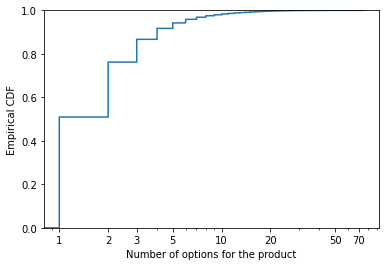

In [6]:
sns.ecdfplot(data=art.groupby("product_code", as_index=False).size(), x="size", log_scale=True)
plt.xlabel("Number of options for the product")
plt.ylabel("Empirical CDF")
plt.xticks([1, 2, 3, 5, 10, 20, 50, 70], [1, 2, 3, 5, 10, 20, 50, 70]);

- Most products have few options (below 4), while there are products with lots of options, e.g. product 783707 is a kind of socks with 75 options.
- The `transactions` table (each row is `(customer_id, article_id)`) is very sparse in terms of `article_id`. Replacing `article_id` with `product_id` may help during training.

,var,count
0,index_group_name,5
1,perceived_colour_value_name,8
2,index_name,10
3,product_group_name,19
4,perceived_colour_master_name,20
5,garment_group_name,21
6,graphical_appearance_name,30
7,colour_group_name,50
8,section_name,56
9,product_type_name,131


Product attributes and their unique values:


Text(0.5, 0, 'Count of unique values')

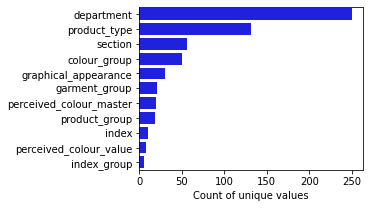

In [35]:
print("Product attributes and their unique values:")
attr = ['index_group_name', 'perceived_colour_value_name', 'index_name',
        'product_group_name', 'perceived_colour_master_name',
        'garment_group_name', 'graphical_appearance_name',
        'colour_group_name', 'section_name',
        'product_type_name', 'department_name']
plt.subplots(figsize=(4,3))
sns.barplot(data=pd.DataFrame([(a[:-5], len(set(art[a]))) for a in attr][::-1], columns=["var", "count"]),
            y="var", x="count", color="blue")
plt.ylabel("")
plt.xlabel("Count of unique values")

- `index_group_name`, `index_name`, `section_name`, and `department_name` are hierarchical
- `product_group_name` and `product_type_name` are also hierarchical.

Count of article_id by several attributes.


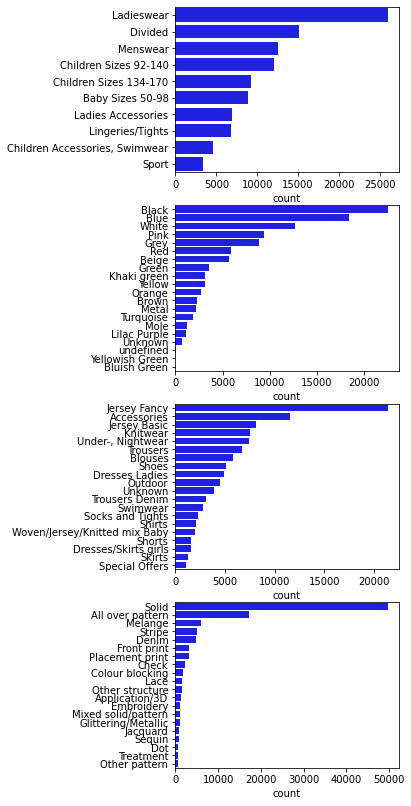

In [39]:
print("Count of article_id by several attributes.")

fig, ax = plt.subplots(4, 1, figsize=(4, 14))

cat_var = ["index_name", "perceived_colour_master_name", "garment_group_name", "graphical_appearance_name"]
for i in range(4):
    sns.countplot(data=art, y=cat_var[i],
                  color="blue", ax=ax[i],
                  order=art[cat_var[i]].value_counts().index[:20],
                  )
    ax[i].set_ylabel("")

Most frequent words in product descriptions in each category (index_name)


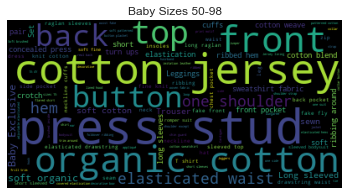

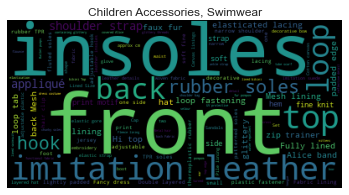

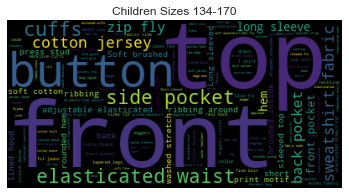

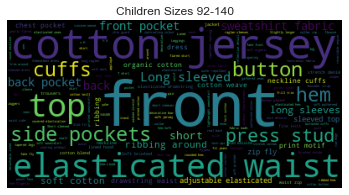

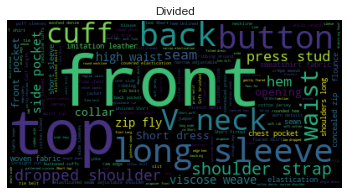

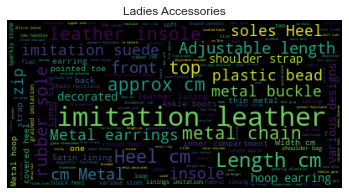

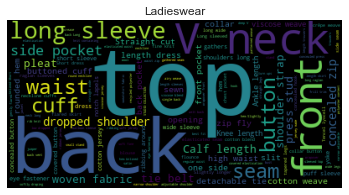

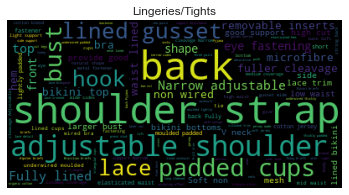

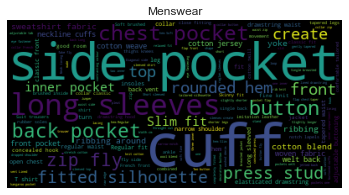

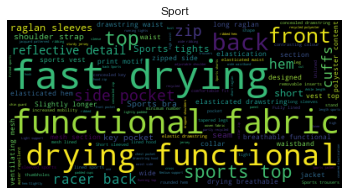

In [117]:
print("Most frequent words in product descriptions in each category (index_name)")
for name, df in art.groupby("index_name"):
    text = " ".join(set(df.detail_desc.apply(str)))
    wc = wordcloud.WordCloud().generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(name)
    plt.show()